## Super Fast Inference [~ 2 min] using multi TPU on PyTorch/XLA

Hi everyone!

My name is Alex Shonenkov, I am researcher, in Love with NLP and DL. 

First of all, I would like to say "BIG THANKS" organizers of this competition: 
https://www.kaggle.com/c/deepfake-detection-challenge

6.5% kernels were crushed on Private Stage, despite on success in Public Stage. And many teams have got score 0.5 for every sample in prediction and get score 0.69314. For example, 3th public place "WestLake" have got this score.
https://www.kaggle.com/c/deepfake-detection-challenge/discussion/145623

I have silver zone solution in computer vision competition, but I didn't take medal.
https://www.kaggle.com/c/deepfake-detection-challenge/discussion/145982



After this precedent I don't see any point in continuing to do any competitions. I would like to share knowledges with you, my friends. 



P.S. I am sorry for high score kernels, but I hope you can improve your solutions using my kernels.

### Main Idea:

Everyone of us knows about how ensemble can improve score. But this competition has some limits on using TPU/GPU: 3 hours. I have made experiment on GPU and understood that one model inference hold 25 min for XLM-Roberta. So for KFold with 5 folds have to hold about ~2.5h. 

After reading this kernel you are able to do ensemble with ~70-80 checkpoints XLM-Roberta theoretically if you want.

***So, lets use MULTI TPU for Inference with data exchange in hard disk during multiprocessing!***

In [1]:
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py > /dev/null
!python pytorch-xla-env-setup.py --version 20200416 --apt-packages libomp5 libopenblas-dev > /dev/null
!pip install transformers > /dev/null
!pip install pandarallel > /dev/null

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3727  100  3727    0     0  49693      0 --:--:-- --:--:-- --:--:-- 49693
Copying gs://tpu-pytorch/wheels/torch-nightly+20200416-cp36-cp36m-linux_x86_64.whl...

Operation completed over 1 objects/87.0 MiB.                                     
Copying gs://tpu-pytorch/wheels/torch_xla-nightly+20200416-cp36-cp36m-linux_x86_64.whl...

Operation completed over 1 objects/115.5 MiB.                                    
Copying gs://tpu-pytorch/wheels/torchvision-nightly+20200416-cp36-cp36m-linux_x86_64.whl...

Operation completed over 1 objects/2.5 MiB.                                      
ERROR: fastai 1.0.60 requires torchvision, which is not installed.
ERROR: catalyst 20.3.3 requires torchvision>=0.2.1, which is not installed.
ERROR: allennlp 0.9.0 has requirement spacy<2.2,>=2.1.0, but you'll have spacy 2.2.3 which is incompati

In [2]:
import numpy as np
import pandas as pd

import os
os.environ['XLA_USE_BF16'] = "1"

from glob import glob
for path in glob(f'../input/*'):
    print(path)

../input/multitpu-inference
../input/jigsaw-multilingual-toxic-comment-classification


In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler

import time
import random
from datetime import datetime
from tqdm import tqdm
tqdm.pandas()

from transformers import XLMRobertaModel, XLMRobertaTokenizer, XLMRobertaConfig
from transformers import AdamW, get_linear_schedule_with_warmup, get_constant_schedule

import re

# !pip install nltk > /dev/null
import nltk
nltk.download('punkt')

from nltk import sent_tokenize

from pandarallel import pandarallel

pandarallel.initialize(nb_workers=2, progress_bar=True)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [4]:
SEED = 42

MAX_LENGTH = 224
BACKBONE_PATH = '../input/multitpu-inference'
CHECKPOINT_PATH = '../input/multitpu-inference/checkpoint-xlm-roberta.bin'


def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [5]:
LANGS = {
    'en': 'english',
    'it': 'italian', 
    'fr': 'french', 
    'es': 'spanish',
    'tr': 'turkish', 
    'ru': 'russian',
    'pt': 'portuguese'
}

def get_sentences(text, lang='en'):
    return sent_tokenize(text, LANGS.get(lang, 'english'))

def exclude_duplicate_sentences(text, lang='en'):
    sentences = []
    for sentence in get_sentences(text, lang):
        sentence = sentence.strip()
        if sentence not in sentences:
            sentences.append(sentence)
    return ' '.join(sentences)

def clean_text(text, lang='en'):
    text = str(text)
    text = re.sub(r'[0-9"]', '', text)
    text = re.sub(r'#[\S]+\b', '', text)
    text = re.sub(r'@[\S]+\b', '', text)
    text = re.sub(r'https?\S+', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = exclude_duplicate_sentences(text, lang)
    return text.strip()

In [6]:
class DatasetRetriever(Dataset):

    def __init__(self, df):
        self.comment_texts = df['comment_text'].values
        self.ids = df['id'].values
        self.tokenizer = XLMRobertaTokenizer.from_pretrained(BACKBONE_PATH)

    def get_tokens(self, text):
        encoded = self.tokenizer.encode_plus(
            text, 
            add_special_tokens=True, 
            max_length=MAX_LENGTH, 
            pad_to_max_length=True
        )
        return encoded['input_ids'], encoded['attention_mask']

    def __len__(self):
        return self.ids.shape[0]

    def __getitem__(self, idx):
        text = self.comment_texts[idx]
        
        #######################################
        # TODO TTA transforms: about it later #
        #######################################
    
        tokens, attention_mask = self.get_tokens(text)
        tokens, attention_mask = torch.tensor(tokens), torch.tensor(attention_mask)

        return self.ids[idx], tokens, attention_mask

In [7]:
%%time

df_test = pd.read_csv(f'../input/jigsaw-multilingual-toxic-comment-classification/test.csv')
df_test['comment_text'] = df_test.parallel_apply(lambda x: clean_text(x['content'], x['lang']), axis=1)
df_test = df_test.drop(columns=['content'])
df_test.head()

CPU times: user 1.15 s, sys: 393 ms, total: 1.55 s
Wall time: 16.3 s


,id,lang,comment_text
0,0,tr,Doctor Who adlı viki başlığına . doctor olarak...
1,1,ru,"Вполне возможно, но я пока не вижу необходимос..."
2,2,it,"Quindi tu sei uno di quelli conservativi , che..."
3,3,tr,Malesef gerçekleştirilmedi ancak şöyle bir şey...
4,4,tr,:Resim:Seldabagcan.jpg resminde kaynak sorunu ...


In [8]:
test_dataset = DatasetRetriever(df_test)

In [9]:
class ToxicSimpleNNModel(nn.Module):

    def __init__(self, backbone):
        super(ToxicSimpleNNModel, self).__init__()
        self.backbone = backbone
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(
            in_features=self.backbone.pooler.dense.out_features*2,
            out_features=2,
        )

    def forward(self, input_ids, attention_masks):
        bs, seq_length = input_ids.shape
        seq_x, _ = self.backbone(input_ids=input_ids, attention_mask=attention_masks)
        apool = torch.mean(seq_x, 1)
        mpool, _ = torch.max(seq_x, 1)
        x = torch.cat((apool, mpool), 1)
        x = self.dropout(x)
        return self.linear(x)


backbone = XLMRobertaModel(XLMRobertaConfig.from_pretrained(BACKBONE_PATH))

In [10]:
import warnings

warnings.filterwarnings("ignore")

import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp


class MultiTPUPredictor:
    
    def __init__(self, model, device):
        if not os.path.exists('node_submissions'):
            os.makedirs('node_submissions')

        self.model = model
        self.device = device

        xm.master_print(f'Model prepared. Device is {self.device}')


    def run_inference(self, test_loader, verbose=True, verbose_step=50):
        self.model.eval()
        result = {'id': [], 'toxic': []}
        t = time.time()
        for step, (ids, inputs, attention_masks) in enumerate(test_loader):
            if verbose:
                if step % 50 == 0:
                    xm.master_print(f'Prediction Step {step}, time: {(time.time() - t):.5f}')

            with torch.no_grad():
                inputs = inputs.to(self.device, dtype=torch.long) 
                attention_masks = attention_masks.to(self.device, dtype=torch.long)
                outputs = self.model(inputs, attention_masks)
                toxics = nn.functional.softmax(outputs, dim=1).data.cpu().numpy()[:,1]

            result['id'].extend(ids.numpy())
            result['toxic'].extend(toxics)

        result = pd.DataFrame(result)
        node_count = len(glob('node_submissions/*.csv'))
        result.to_csv(f'node_submissions/submission_{node_count}_{datetime.utcnow().microsecond}.csv', index=False)

In [11]:
net = ToxicSimpleNNModel(backbone=backbone)
checkpoint = torch.load(CHECKPOINT_PATH, map_location=torch.device('cpu'))
net.load_state_dict(checkpoint);

checkpoint = None
del checkpoint

In [12]:
def _mp_fn(rank, flags):
    device = xm.xla_device()
    model = net.to(device)

    test_sampler = torch.utils.data.distributed.DistributedSampler(
        test_dataset,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=False
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=16,
        sampler=test_sampler,
        pin_memory=False,
        drop_last=False,
        num_workers=1
    )

    fitter = MultiTPUPredictor(model=model, device=device)
    fitter.run_inference(test_loader)

In [13]:
%%time

FLAGS={}
xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=8, start_method='fork')

Model prepared. Device is xla:1
Prediction Step 0, time: 0.24685
Prediction Step 50, time: 22.31887
Prediction Step 100, time: 32.36932
Prediction Step 150, time: 43.08153
Prediction Step 200, time: 52.97960
Prediction Step 250, time: 63.47994
Prediction Step 300, time: 73.24545
Prediction Step 350, time: 83.16676
Prediction Step 400, time: 93.88289
Prediction Step 450, time: 104.32985
CPU times: user 177 ms, sys: 275 ms, total: 453 ms
Wall time: 2min 23s


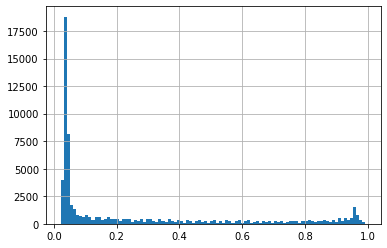

In [14]:
submission = pd.concat([pd.read_csv(path) for path in glob('node_submissions/*.csv')]).groupby('id').mean()
submission['toxic'].hist(bins=100)

> On this stage my submission has 0.9417 with single checkpoint. But let me say thanks author @hamditarek for perfect ensemble https://www.kaggle.com/hamditarek/ensemble

> Let's blend with 1:1

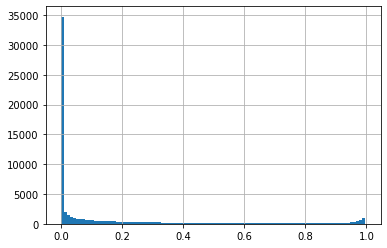

In [15]:
ensemble = pd.read_csv('../input/multitpu-inference/submission-ensemble.csv', index_col='id')
ensemble['toxic'].hist(bins=100)

In [16]:
def scale_min_max_submission(submission):
    min_, max_ = submission['toxic'].min(), submission['toxic'].max()
    submission['toxic'] = (submission['toxic'] - min_) / (max_ - min_)
    return submission

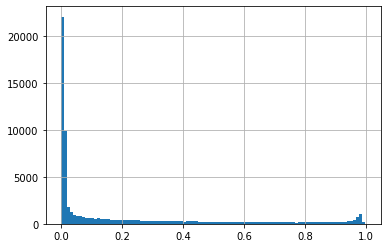

In [17]:
submission['toxic'] = (scale_min_max_submission(submission)['toxic'] + scale_min_max_submission(ensemble)['toxic']) / 2
submission['toxic'].hist(bins=100)

In [18]:
submission.to_csv('submission.csv')

### Thanks a lot for reading my kernel! I hope it helps you.

- So, during research in this competition I implemented some NLP augmentations with format of this great computer vision library: https://github.com/albumentations-team/albumentations 

- Also for training model I have created multi lingual synthesic generation of toxic/non-toxic comments using dataset open-subtitles. 

- Also I have stable validation (GroupKFold).

- Later I will publish 5-Fold Super Fast Inference for XLM-Roberta

- Also I would like to publish Training Pipeline


And.. If you like this format of notebooks I would like continue to make kernels with realizations of my ideas. 

If this notebooks will take gold zone, I would like to publish above-stated ideas.
